# Kullback-Leibler情報量と記述統計

黒木玄

2019-09-13～2019-09-23, 2019-10-15, 2020-01-03, 2020-11-02

* Copyright 2019, 2020 Gen Kuroki
* License: [MIT](https://opensource.org/licenses/MIT)

このファイルのJupyter notebook版は

* [Kullback-Leibler情報量と記述統計 Jupyter notebook版](https://nbviewer.jupyter.org/github/genkuroki/Statistics/blob/master/KL%20information%20and%20descriptive%20statistics.ipynb)

で閲覧でき, PDF版は

* [Kullback-Leibler情報量と記述統計 PDF版](https://genkuroki.github.io/documents/Statistics/KL%20information%20and%20descriptive%20statistics.pdf)

で閲覧できる.

$
\newcommand\eps{\varepsilon}
\newcommand\ds{\displaystyle}
\newcommand\Z{{\mathbb Z}}
\newcommand\R{{\mathbb R}}
\newcommand\C{{\mathbb C}}
\newcommand\QED{\text{□}}
\newcommand\root{\sqrt}
\newcommand\bra{\langle}
\newcommand\ket{\rangle}
\newcommand\d{\partial}
\newcommand\sech{\operatorname{sech}}
\newcommand\cosec{\operatorname{cosec}}
\newcommand\sign{\operatorname{sign}}
\newcommand\sinc{\operatorname{sinc}}
\newcommand\real{\operatorname{Re}}
\newcommand\imag{\operatorname{Im}}
\newcommand\Li{\operatorname{Li}}
\newcommand\PROD{\mathop{\coprod\kern-1.35em\prod}}
$

## 追記
MathJaxが重くて鬱陶しいので上記ファイルを自分用のメモとして式の部分は別のドキュメントにまとめ、計算部分だけ抜き出してあります。

もちろん式に関しては別ファイルを参照しなければならない不便があるので、その場合は黒木さんのオリジナルのファイルを確認してください。

いくつか追加実験もいれてあります。

# 目次
- [1 Kullback-Leibler情報量とSanovの定理](#Kullback-Leibler情報量とSanovの定理)
    - [1.1 Stirlingの公式](#Stirlingの公式)
    - [1.2 KL情報量](#KL情報量)
- [2 平均と分散](#平均と分散)
    - [2.4 平均と分散の推定の例](#平均と分散の推定の例)
- [3 中央値](#中央値)
    - [3.6 中央値の推定の例](#中央値の推定の例)
- [4 最頻値](#最頻値)
    - [4.3 最頻値の近似的な推定の例](#最頻値の近似的な推定の例)
- [5 加法平均と乗法平均](#加法平均と乗法平均)
    - [5.3 ガンマ分布モデルによる推定の例](#ガンマ分布モデルによる推定の例)

## インポートと関数定義
- [目次へ](#目次)

In [1]:
using Base64
displayfile(mime, file; tag="img") = open(file) do f
    display("text/html", """<$tag src="data:$mime;base64,$(base64encode(f))">""")
end

using Distributions
using Statistics
using StatsBase
using LaTeXStrings

using StatsPlots
using Plots
default(:bglegend, plot_color(default(:bg), 0.5))
default(:fglegend, plot_color(ifelse(isdark(plot_color(default(:bg))), :white, :black), 0.6));
pal = palette(:default)

pyplotclf() = if backend() == Plots.PyPlotBackend(); PyPlot.clf(); end 

function retina(P::Plots.Plot; scale=3)
    Q = deepcopy(P)
    Q[:dpi] = round(Int, scale*P[:dpi])
    base64 = base64encode(show, MIME("image/png"), Q)
    mime = "image/png"
    width = P[:size][1]
    display("text/html", """<img width=$(width) src="data:$(mime);base64,$(base64)"/>""")
    pyplotclf()
end

retina(; scale=3) = (P -> retina(P; scale=scale))

pyplot(fmt=:auto, size=(400, 250), titlefontsize=10)

using Random
using QuadGK

using SpecialFunctions
SpecialFunctions.lgamma(x::Real) = logabsgamma(x)[1]

## Kullback-Leibler情報量とSanovの定理
- [目次へ](#目次)

### Stirlingの公式
- [目次へ](#目次)

#### グラフ
被積分函数 $f(x)=n\log x - x$ と $x=n+\sqrt{n}\,y$ で得られるその近似 $g(y) = n \log n - n - y^2/2$ を $n=1000$ で比較してみよう.  


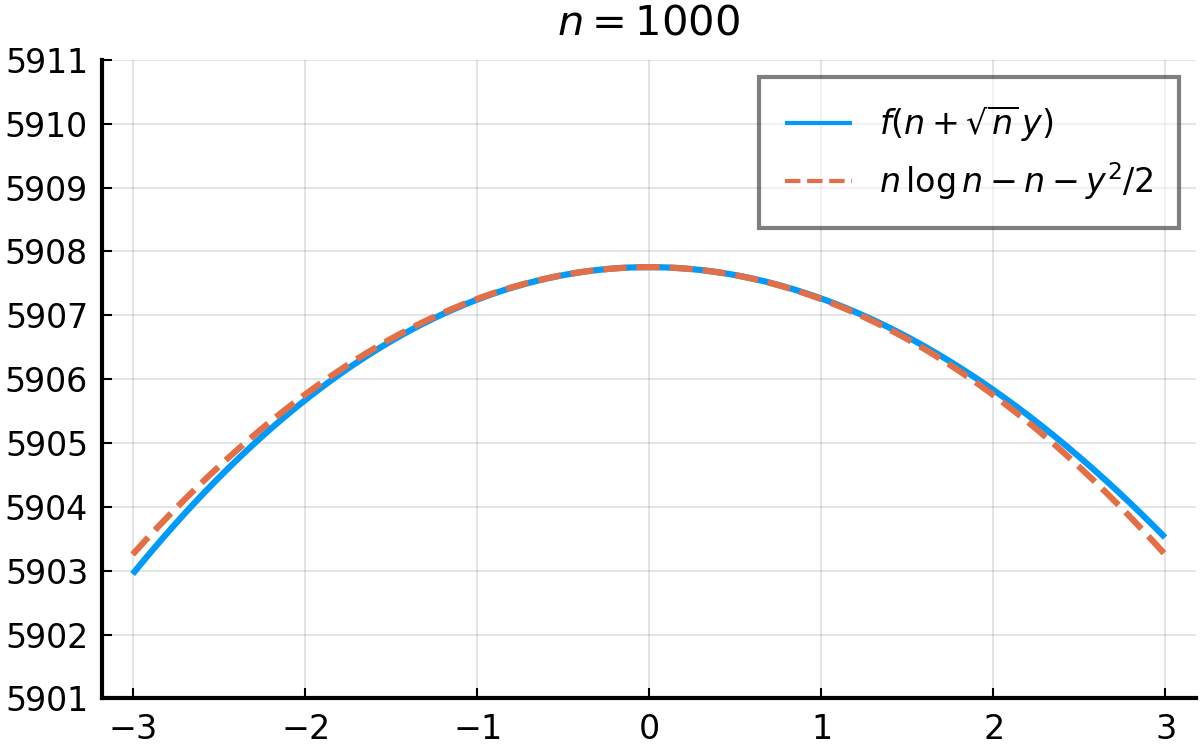

In [2]:
n = 1000
f(x) = n*log(x) - x
g(y) = n*log(n) - n - y^2/2
y = range(-3, 3, length=400)
plot(title="\$n = $n\$", ylim=(5901, 5911), ytick=5901:5911)
plot!(y, @.(f(n + √n*y)), label=L"f(n+\sqrt{n}\,y)", lw=1.5)
plot!(y, g.(y), label=L"n\,\log\,n - n - y^2/2", lw=1.5, ls=:dash) |> retina

#### グラフの内容確認
確かによく一致していて, 概要は次の通り.

- $y<0$ では $f(y) < g(y)$.
- $y>0$ ではその逆.

次に紹介する「差のグラフ」を見るともっとはっきりわかる.
実際に積分すると, その違いが互いに打ち消し合うことによって精度が上がる仕組みになっている.

#### 差を取る


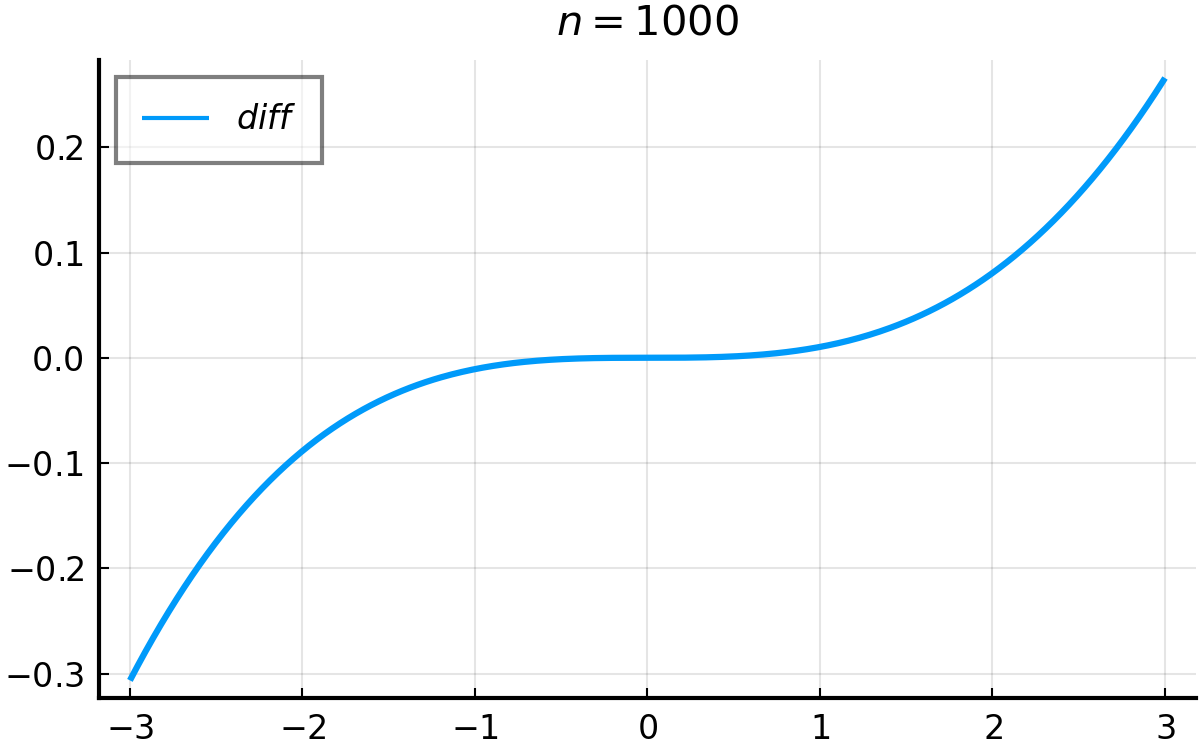

In [3]:
plot(title="\$n = $n\$")
plot!(y, @.(f(n + √n*y)) - g.(y), label=L"diff", lw=1.5) |> retina

#### グラフ: 対数版のStirlingの公式

$$
\log n! = n \log n - n + \frac{1}{2}\log n + \log\sqrt{2\pi} + o(1)
$$

対数版を数値的に確認してみよう.


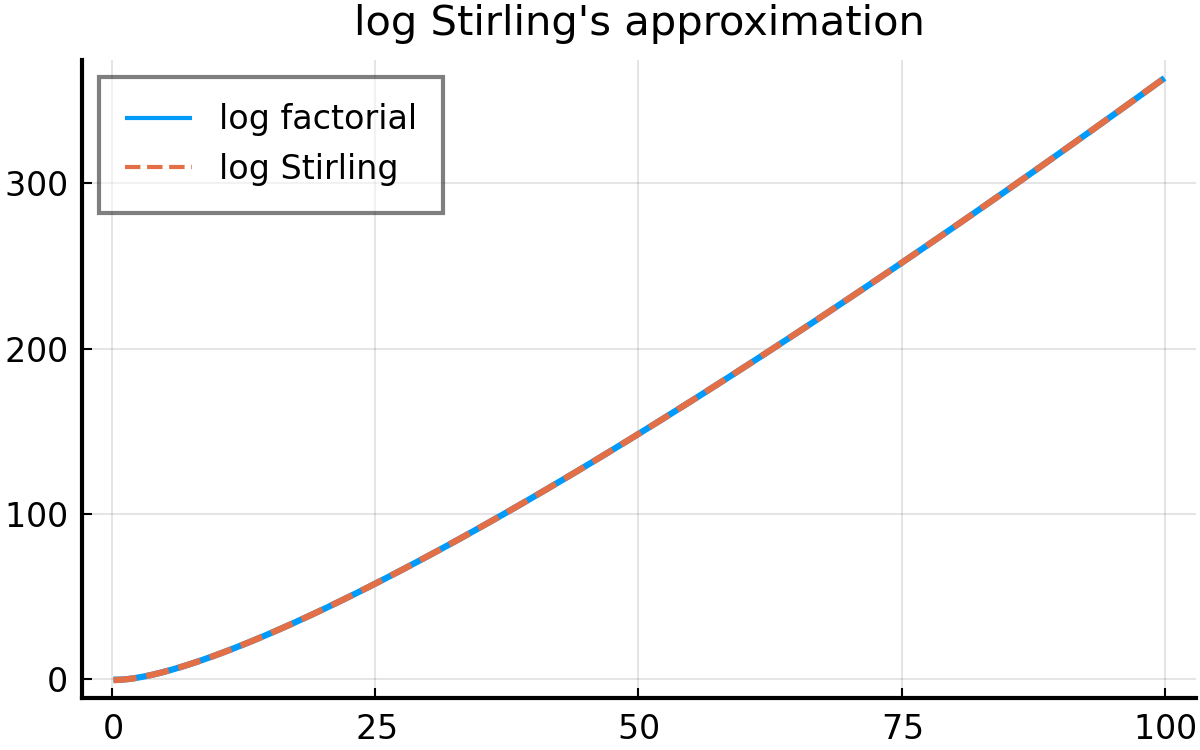

In [4]:
logfact(n) = lgamma(n+1)
logstirling(n) = n*log(n) - n + 1/2*log(n) + log(√(2π))
x = range(0.1, 100, length=400)
plot(title="log Stirling's approximation")
plot!(x, logfact.(x), label="log factorial", lw=1.5)
plot!(x, logstirling.(x), label="log Stirling", lw=1.5, ls=:dash) |> retina

#### グラフの内容確認
このようにStirlingの公式による近似の精度は非常に高く, ほとんどぴったり一致しているように見える. 

#### 階乗とStirlingの公式が一致しないのはいつか？
階乗とStirlingの公式による近似があまり一致しないのは $n$ が小さな場合だけである.


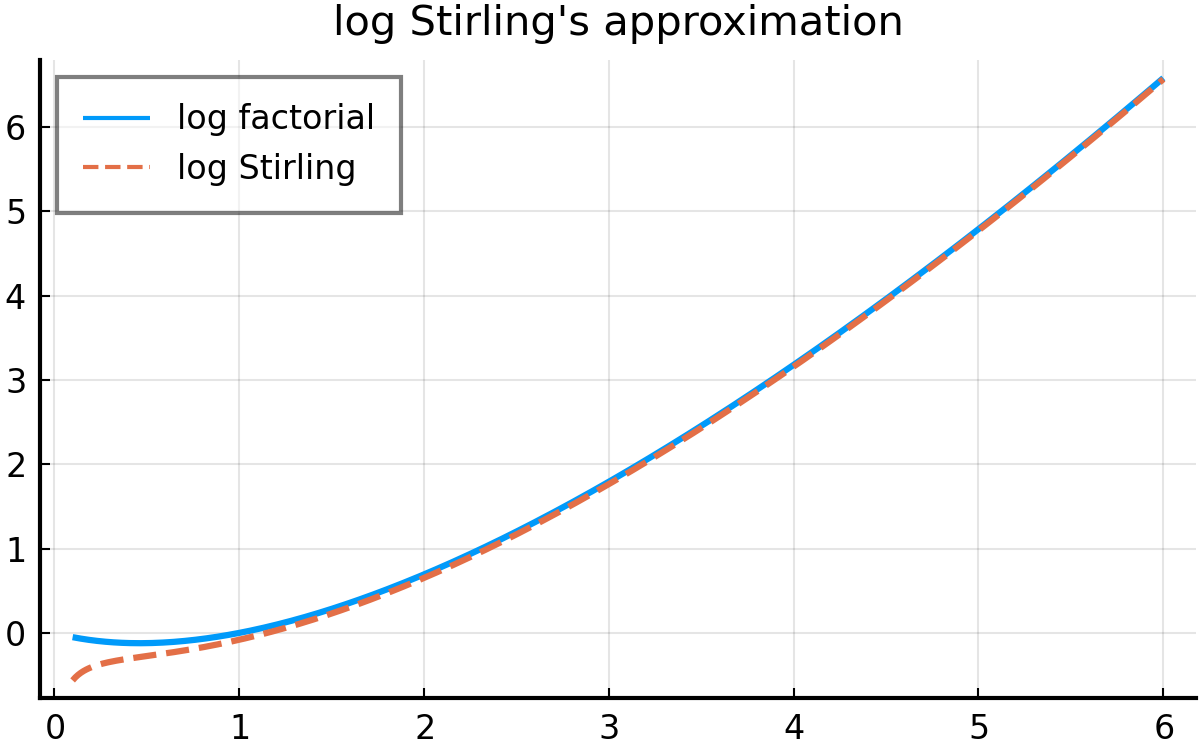

In [5]:
x = range(0.1, 6, length=400)
plot(title="log Stirling's approximation")
plot!(x, logfact.(x), label="log factorial", lw=1.5)
plot!(x, logstirling.(x), label="log Stirling", lw=1.5, ls=:dash) |> retina

### 差を取ってみる
グラフを描いた範囲では差が単調に減っていることがわかります。


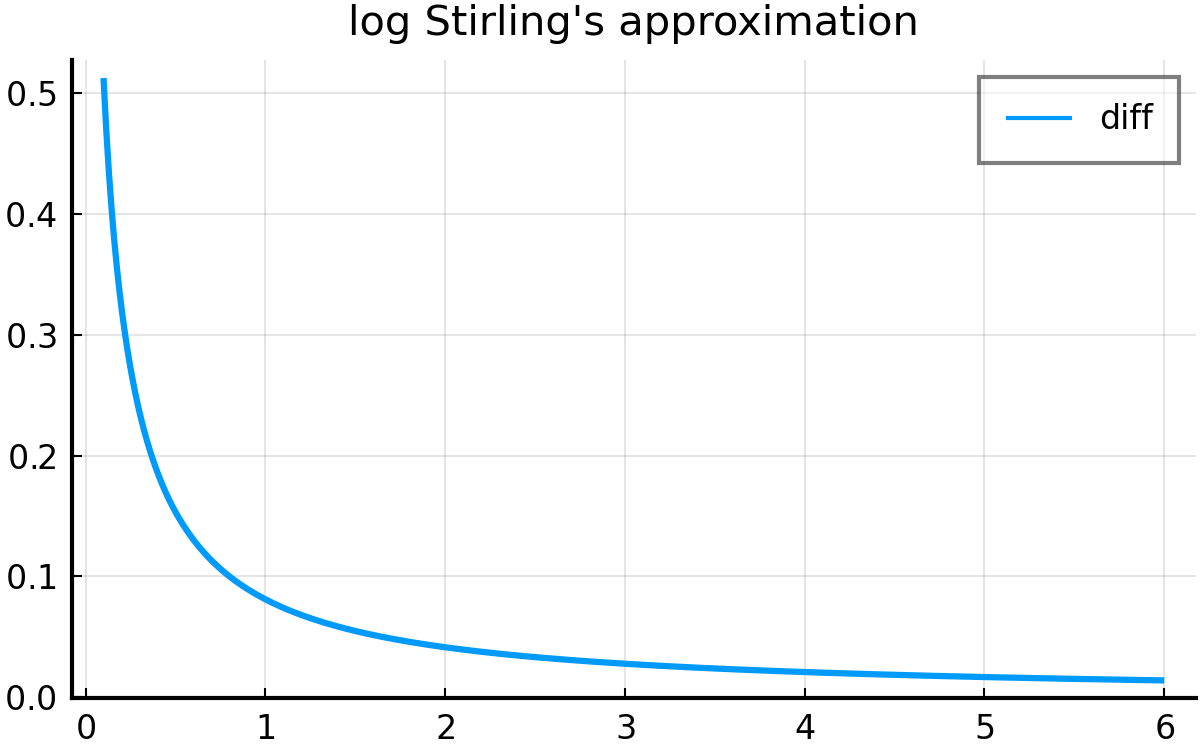

In [6]:
x = range(0.1, 6, length=400)
plot(title="log Stirling's approximation")
plot!(x, logfact.(x) - logstirling.(x), label="diff", lw=1.5) |> retina

### KL情報量
- [目次へ](#目次)

#### グラフ
$r=2$ の二項分布の確率の場合のSanovの定理を数値的に確認してみよう.
そのためには $k=nq$ の場合に次の式を比較すればいい.
\begin{align}
\text{logprob_bin}
&=
-\frac{1}{n}\log\frac{n!p^k (1-p)^{n-k}}{k!(n-k)!}, \\
\text{kl_bin}
&=
q \log \frac{q}{p} + (1-q)\log\frac{1-q}{1-p}.
\end{align}
$n=200$, $p=0.4$ でこれら2つを比較してみよう.


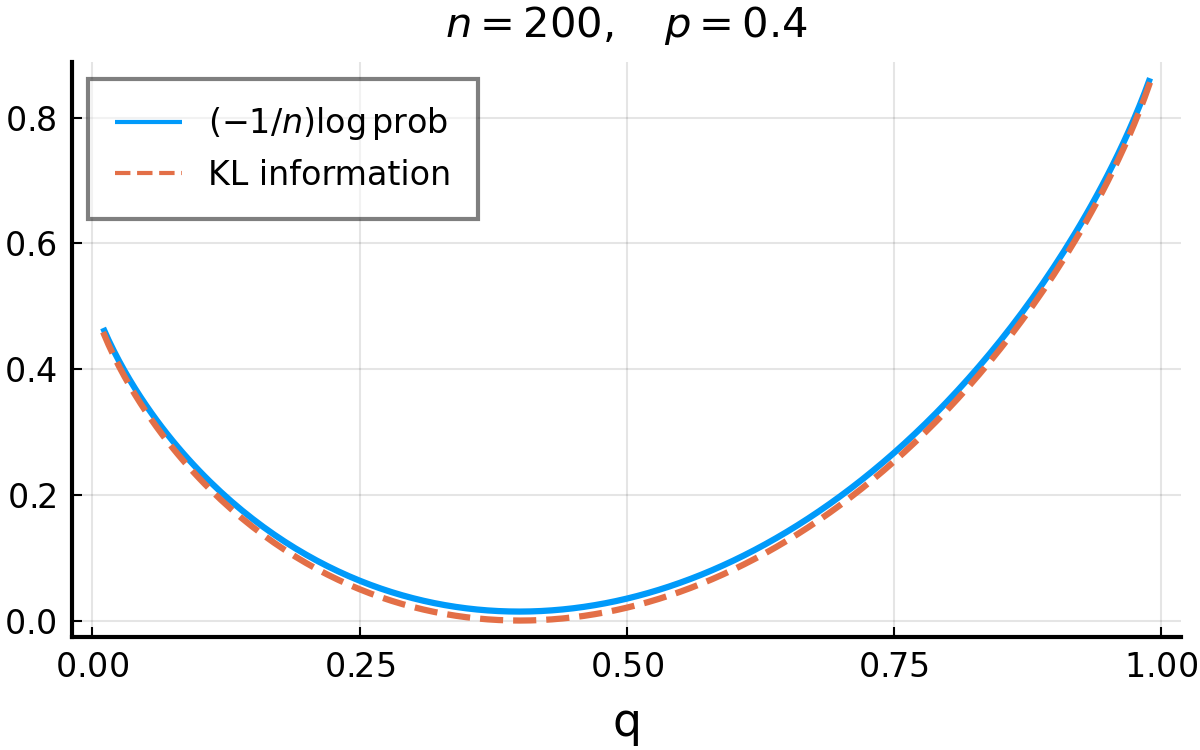

In [7]:
logprob_bin(n, k, p) = -1/n * (logfact(n) + k*log(p) + (n-k)*log(1-p) - logfact(k) - logfact(n-k))
kl_bin(q, p) = q*log(q/p) + (1-q)*log((1-q)/(1-p))

n = 200
p = 0.4
q = range(0.01, 0.99, step=0.005)

plot(xlabel="q", title="\$n = $n, \\quad p = $p\$")
plot!(q, logprob_bin.(n, n*q, p), label=L"(-1/n)\log\,\mathrm{prob}", lw=1.5)
plot!(q, kl_bin.(q, p), label="KL information", lw=1.5, ls=:dash) |> retina

#### グラフの確認
確かに2つはよく一致している.

#### 差を取ってみる


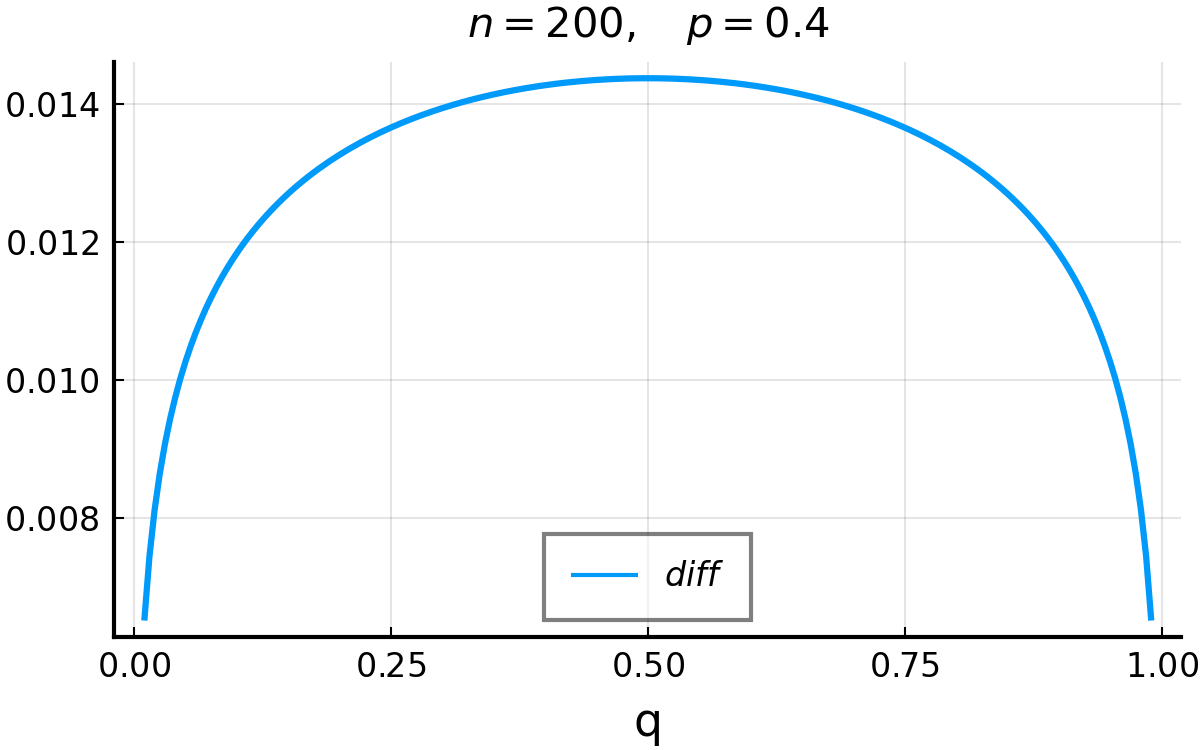

In [8]:
plot(xlabel="q", title="\$n = $n, \\quad p = $p\$")
plot!(q, logprob_bin.(n, n*q, p) - kl_bin.(q, p), label=L"diff", lw=1.5) |> retina

## 平均と分散
- [目次へ](#目次)

### 平均と分散の推定の例：ガンマ分布で生成したサンプルを正規分布で推測する
- [目次へ](#目次)

#### 下記実行結果から転記
- `Gamma(4.0, 0.25)`：[Gamma(α, θ)](https://github.com/JuliaStats/Distributions.jl/blob/master/src/univariate/continuous/gamma.jl) # Gamma distribution with shape α and scale θ

#### オリジナルのガンマ分布のデータ
- 平均：1.0
- 標準偏差：0.5

#### サンプルの標本平均・標本標準偏差
- 標本平均：0.9955804447660762
- 標本標準偏差：0.49273267483475164

mean(gdist) = 1.0
std(gdist) = 0.5
mean(X) = 0.9955804447660762
std(X; corrected = false) = 0.49273267483475164
normal_gdist = fit_mle(Normal, X) = Normal{Float64}(μ=0.9955804447660762, σ=0.4927326748347515)



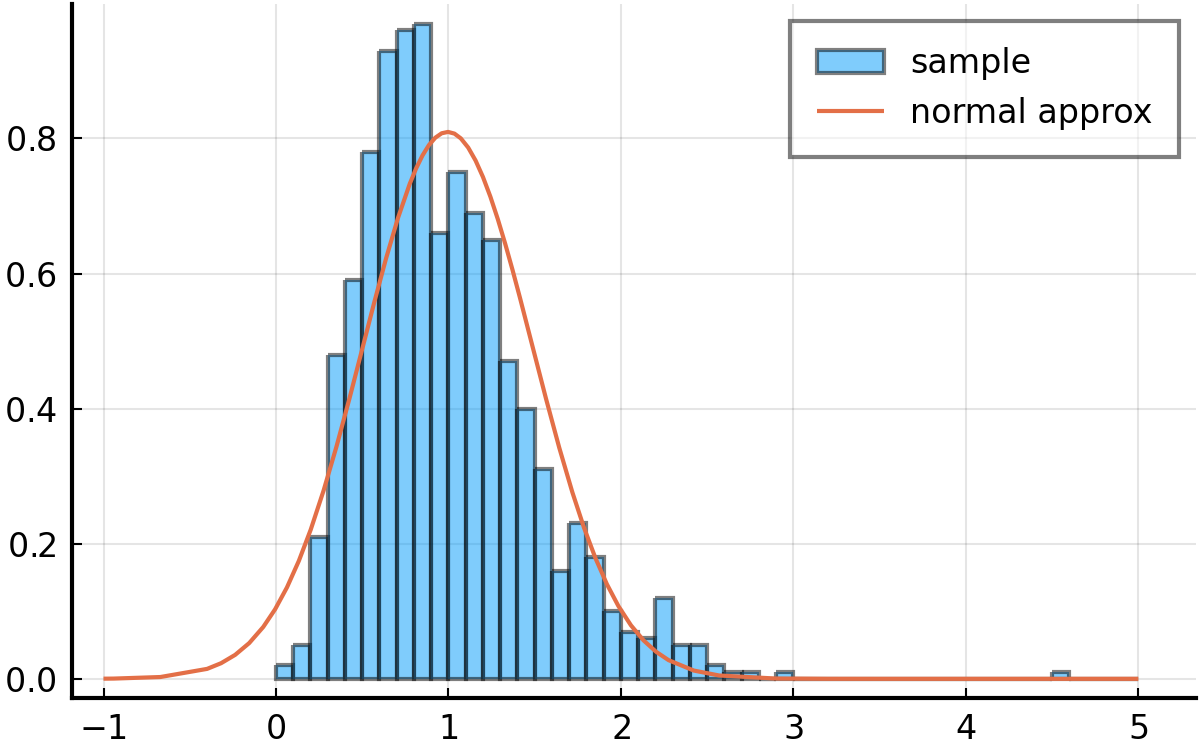

In [9]:
seed = 37346491
gparam1 = 4.0
gparam2 = 0.25
N = 1000

Random.seed!(seed)

gdist = Gamma(gparam1, gparam2)
@show mean(gdist)
@show std(gdist)

X = rand(gdist, N)
@show mean(X)
@show std(X; corrected=false)

# 最尤推定
@show normal_gdist = fit_mle(Normal, X)

sleep(0.1)
histogram(X; normed=true, bins=range(0, 5, step=0.1), alpha=0.5, label="sample")
plot!(x -> pdf(normal_gdist, x), -1, 5; label="normal approx") |> retina

#### 尤度函数のプロット

 63.602690 seconds (32.54 M allocations: 1.289 GiB, 0.78% gc time)



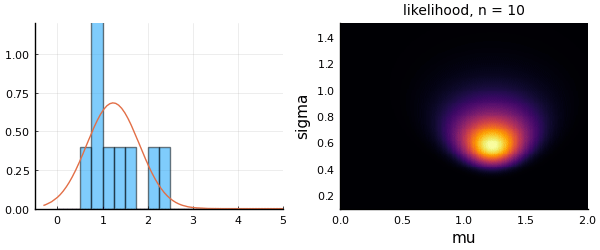

┌ Info: Saved animation to 
│   fn = C:\Users\4429s\codes\mathcodes\julia\statistics\images\004_lik_normal.gif
└ @ Plots C:\Users\4429s\.julia\packages\Plots\6EMd6\src\animation.jl:104


In [10]:
Random.seed!(seed)

# ガンマ分布でサンプル生成
gdist = Gamma(gparam1, gparam2)
N = 1000
XX = rand(gdist, N)

ns = [10;10;10;10;10:3:300;300;300;300;300]
@time anim = @animate for n in ns
    X = @view XX[1:n]

    # 正規分布で最尤推定
    normal_gdist = fit_mle(Normal, X)
    P1 = histogram(X; normed=true, bins=range(0, 5, step=0.25), alpha=0.5, label="sample")
    plot!(x -> pdf(normal_gdist, x); label="normal approx")
    plot!(legend=false, xlim=(-0.5, 5), ylim=(0, 1.2))

    # 対数尤度
    loglik(μ, σ) = sum(logpdf(Normal(μ, σ), x) for x in X)
    μ = range(0, 2, length=200)
    σ = range(0.1, 1.5, length=200)
    # ヒートマップは尤度を見る
    P2 = heatmap(μ, σ, exp.(loglik.(μ', σ)); xlabel="mu", ylabel="sigma",
        size=(300, 320), colorbar=false, title="likelihood, n = $n")
    
    plot(P1, P2, size=(600, 250))
end
pyplotclf()
gif(anim, "images/004_lik_normal.gif", fps=10)
displayfile("image/gif", "images/004_lik_normal.gif")

#### グラフの観察
- $n$が大きくなるにつれて、尤度に関して$\mu$と$\sigma$の台の広がりがどんどん小さくなっています。
- 尤度の分布の様子を見ると、実際に上で確認したガンマ分布の平均・標準偏差に実際に近づいてもいます。

## 中央値
- [目次へ](#目次)

### 中央値の推定の例：ガンマ分布をラプラス分布モデルで最尤推定
- [目次へ](#目次)

[QuadGK](https://juliamath.github.io/QuadGK.jl/stable/)は次の通り。

>- one-dimensional numerical integration in Julia using adaptive Gauss-Kronrod quadrature.
>- Juliaでのガウス-クロンロッド求積法による一次元の数値積分法

ラプラス分布については黒木さんのオリジナルか、別に整理しているPDFを参考にすること。
#### 中央値（下記実行結果から転記）
- a₀ = median(gdist) = 0.9180151872127242
- b₀ = 0.3852143558605696
- a_hat = median(X) = 0.901053827946683
- b_hat = mean((abs(x - a_hat) for x = X)) = 0.3773964067342682

a₀ = median(gdist) = 0.9180151872127242
b₀ = 0.3852143558605696
a_hat = median(X) = 0.901053827946683
b_hat = mean((abs(x - a_hat) for x = X)) = 0.3773964067342682
laplace_gdist = Laplace(a_hat, b_hat) = Laplace{Float64}(μ=0.901053827946683, θ=0.3773964067342682)



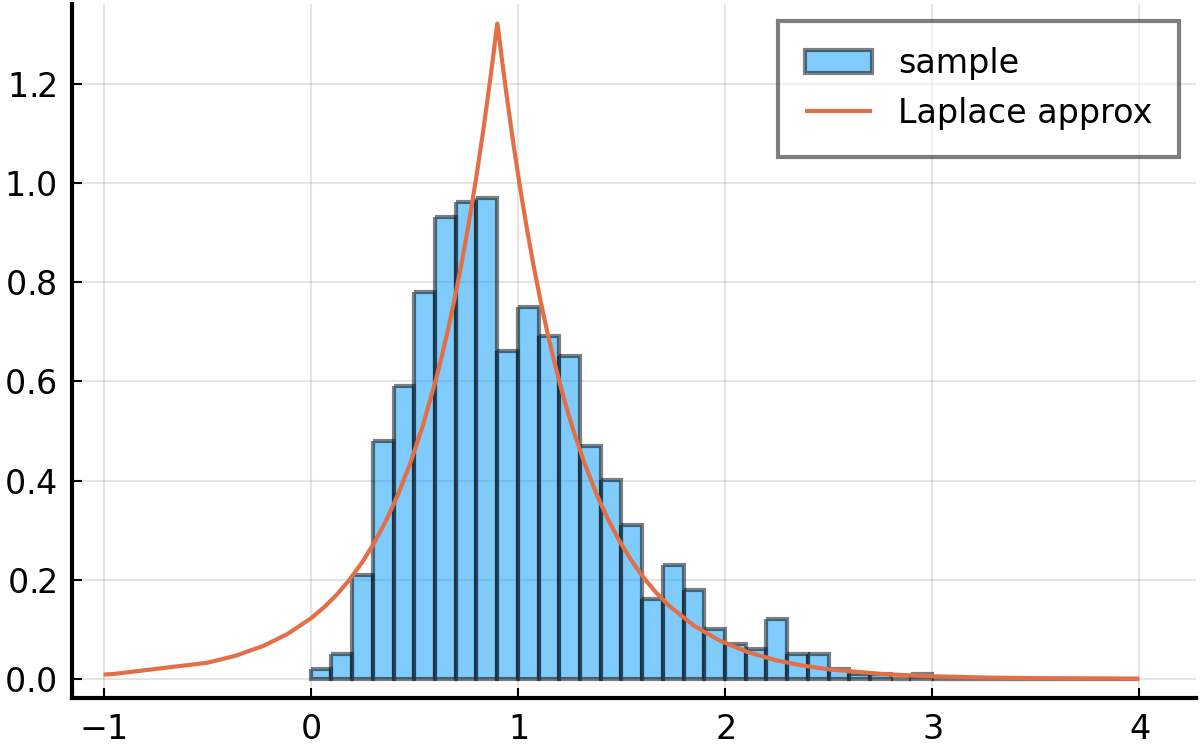

In [11]:
Random.seed!(seed)

# ガンマ分布
gdist = Gamma(gparam1, gparam2)
@show a₀ = median(gdist) # 中央値
b₀ = quadgk(x->pdf(gdist, x)*abs(x-a₀), 0, Inf)[1] # ガンマ分布による期待値計算
@show b₀

X = rand(gdist, N)
@show a_hat = median(X) # 標本の中央値
@show b_hat = mean(abs(x - a_hat) for x in X)

@show laplace_gdist = Laplace(a_hat, b_hat)

sleep(0.1)
histogram(X; bins=range(0, 4, step=0.1), normed=true, alpha=0.5, label="sample")
plot!(x -> pdf(laplace_gdist, x), -1, 4; label="Laplace approx") |> retina

### 尤度函数のプロット

 66.946000 seconds (26.84 M allocations: 982.404 MiB, 0.50% gc time)



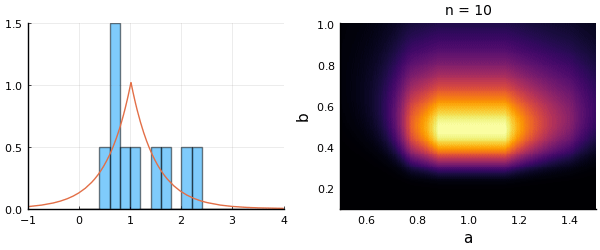

┌ Info: Saved animation to 
│   fn = C:\Users\4429s\codes\mathcodes\julia\statistics\images\004_lik_laplace.gif
└ @ Plots C:\Users\4429s\.julia\packages\Plots\6EMd6\src\animation.jl:104


In [12]:
Random.seed!(seed)

gdist = Gamma(gparam1, gparam2)
N = 1000
XX = rand(gdist, N)

ns = [10;10;10;10;10;10:10:1000;1000;1000;1000;1000]
@time anim = @animate for n in ns
    X = @view XX[1:n]

    # サンプルの中央値を取得
    a_hat = median(X)
    b_hat = mean(abs(x - a_hat) for x in X)
    P1 = histogram(X; bins=range(0, 4, step=0.2), normed=true, alpha=0.5, label="sample")
    # サンプルの値からラプラス分布を生成
    laplace_gdist = Laplace(a_hat, b_hat)
    plot!(x -> pdf(laplace_gdist, x), -1, 4; label="Laplace approx")
    plot!(legend=false, xlim=(-1, 4), ylim=(0, 1.5))

    # ヒートマップでは尤度を計算
    loglik(a, b) = sum(logpdf(Laplace(a, b), x) for x in X)
    a = range(0.5, 1.5, length=200)
    b = range(0.1, 1.0, length=200)
    P2 = heatmap(a, b, exp.(loglik.(a', b)); xlabel="a", ylabel="b",
        size=(300, 320), colorbar=false, title="n = $n")
    
    plot(P1, P2, size=(600, 250))
end
pyplotclf()
gif(anim, "images/004_lik_laplace.gif", fps=10)
displayfile("image/gif", "images/004_lik_laplace.gif")

#### グラフ
- 元のガンマ分布自体の中央値：0.9180151872127242
- 実際に $a = 0.9$ あたりに収束していく

## 最頻値
- [目次へ](#目次)

### 最頻値の近似的な推定の例：正規分布の混合モデルからサンプルを生成
- [目次へ](#目次)


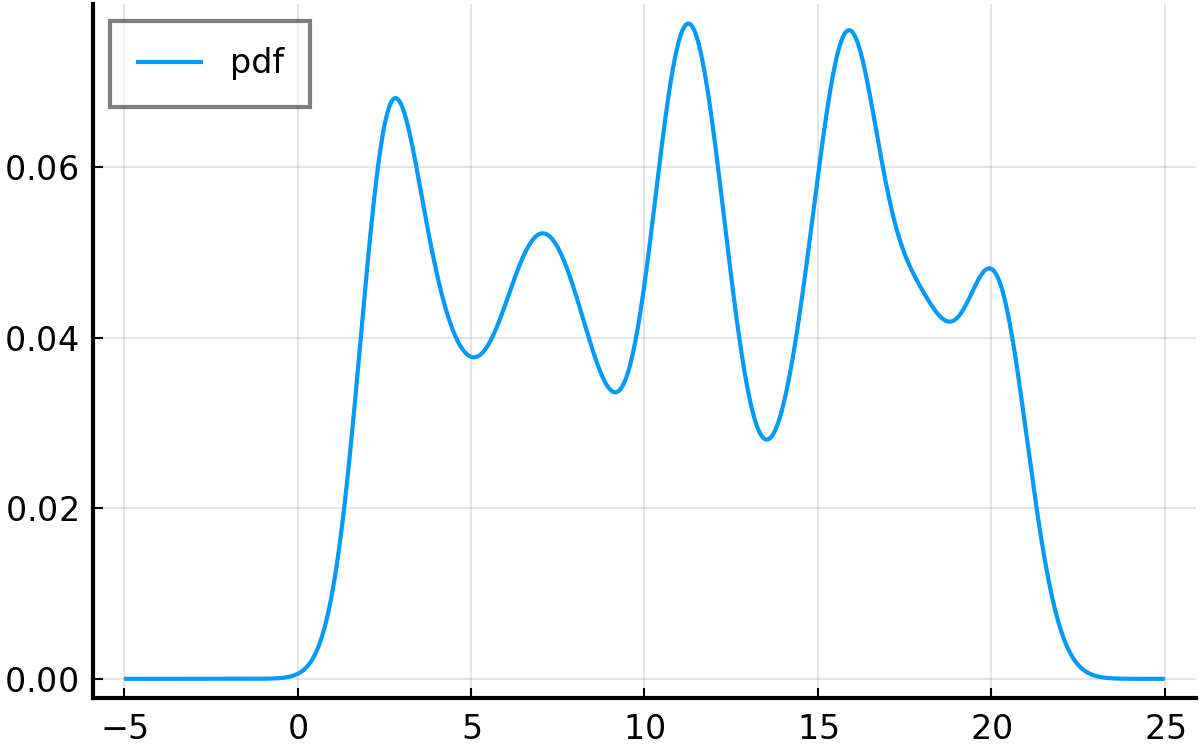

In [13]:
Random.seed!(seed)

r = 10
noise1 = 0.4randn(r)
noise2 = 0.2randn(r)
dist = MixtureModel([Normal(2k+noise1[k], 1.0+noise2[k]) for k in 1:r], [1/r for k in 1:r])
x = range(-5, 2r+5, length=2000)
plot(x, pdf.(dist, x), legend=:topleft, label="pdf") |> retina

#### 分布の最頻値を確認する
後でこの値を推測するので、この値を覚えておくこと。

In [14]:
a₀ = x[findmax(pdf.(dist, x))[2]]

11.268134067033516

#### サンプル$X$を生成してヒストグラムを描く
最頻値はグラフの下に描いてあるので、
最頻値がもとの分布の最頻値とずれていることも確認しておきましょう。

##### メモ
- [StatsBase.mad](https://juliastats.org/StatsBase.jl/v0.21/scalarstats.html)

> Compute the median absolute deviation (MAD) of v around center (by default, around the median).

(mean(X), std(X)) = (11.303196877444563, 5.777057123787423)
(median(X), StatsBase.mad(X; normalize = false)) = (11.403142548529633, 4.892944766045574)



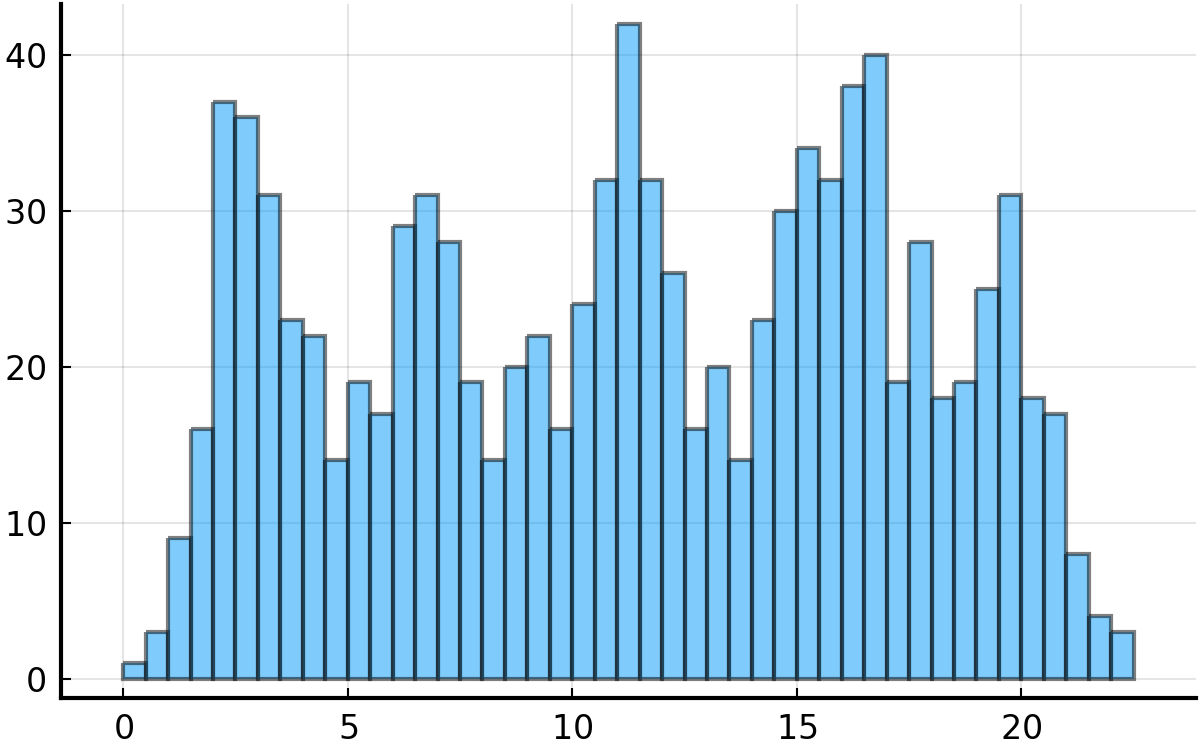

mode(X) = 16.73842542695508


In [15]:
X = rand(dist, 1000)
@show mean(X), std(X)
@show median(X), StatsBase.mad(X; normalize=false)
@show mode(X)
histogram(X; bin=40, legend=false, alpha=0.5) |> retina

#### 関数$f$は平均0の正規分布
下の`Ln`は経験損失関数$L_n$です。
あとで分散を動かして色々な挙動を調べます。


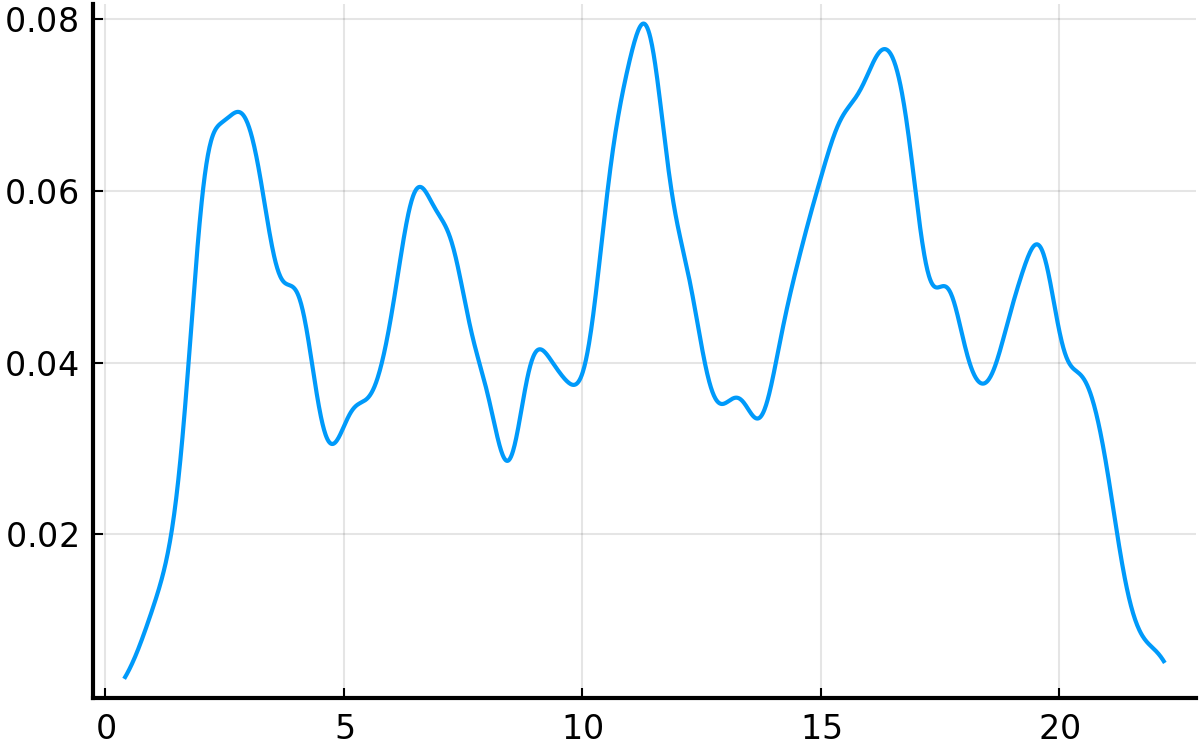

11.289961855332413

In [16]:
f(x, ε) = pdf(Normal(0, ε), x)
Ln(a; ε=0.3) = mean(f(x-a, ε) for x in X)

a = range(extrema(X)..., length=2000)
plot(a, Ln.(a), legend=false) |> retina
a_hat = a[findmax(Ln.(a))[2]]

#### 最頻値の推測
サンプルの分布を丸めるために使った正規分布の標準偏差を $0.1$ から $3.0$ まで動かして最頻値の推定値がどのように変化するかをプロットしています。
このサンプルの例では次のようになっています。

- 標準偏差が小さいうちは最頻値の推定値が $11$ 程度
- 標準偏差がある値を超えると突然 $16$ 程度に最頻値の推定値がジャンプする

この $16$ はサンプル$X$の最頻値に近い値です。


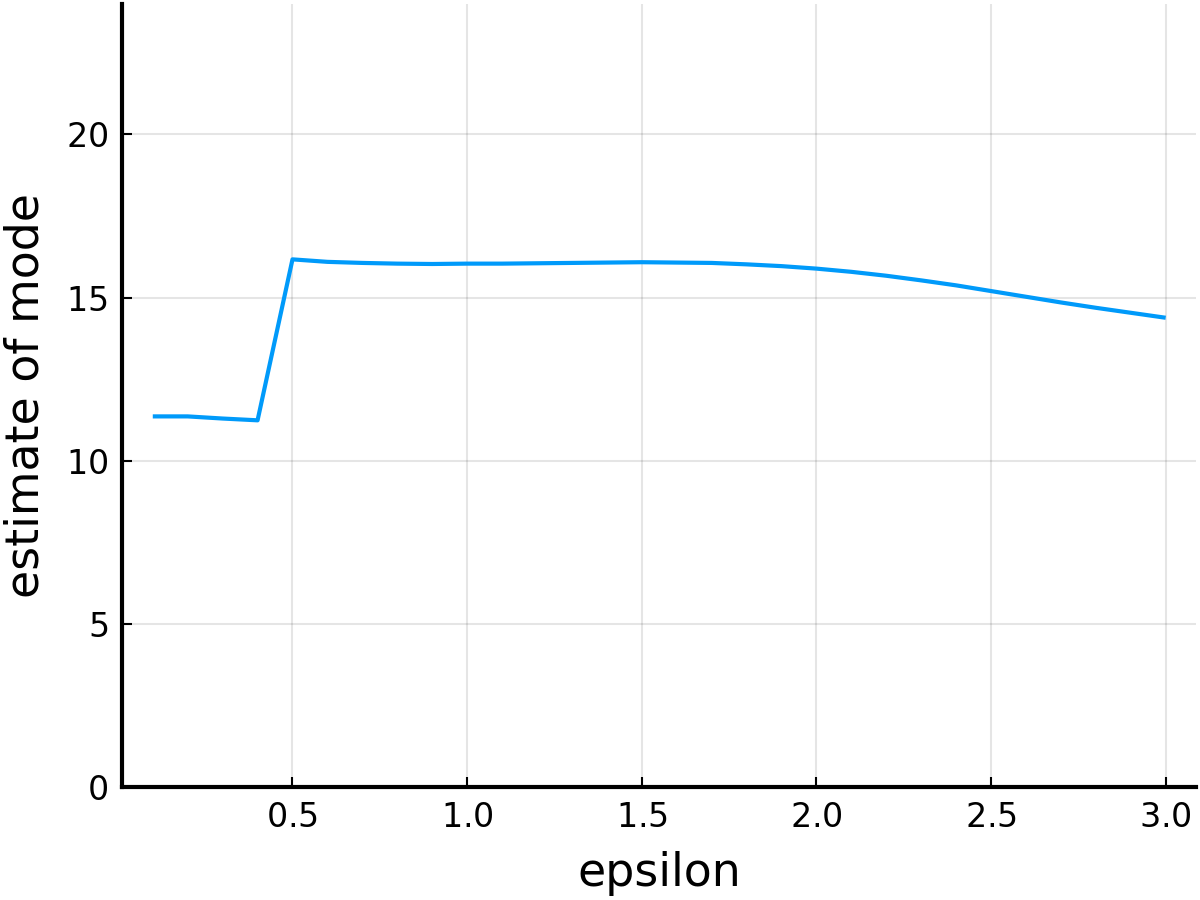

In [17]:
εs = range(0.1, 3.0, step=0.1)
y = [a[findmax(Ln.(a; ε=ε))[2]] for ε in εs]
plot(εs, y; size=(400, 300), legend=false, ylim=(0, 24),
    xlabel="epsilon", 
    ylabel="estimate of mode") |> retina

#### 標準偏差$\varepsilon$の変化とカーネル密度推定
分散を大きくしていくので分布が滑らかになっていって、元の分布のデータからサンプルの特徴にシフトしていく様子が見られます。

メモ：KDEは[カーネル密度推定（kernel density estimation）](https://ja.wikipedia.org/wiki/%E3%82%AB%E3%83%BC%E3%83%8D%E3%83%AB%E5%AF%86%E5%BA%A6%E6%8E%A8%E5%AE%9A)の略で正しい？

 11.286532 seconds (2.98 M allocations: 138.180 MiB, 0.69% gc time)



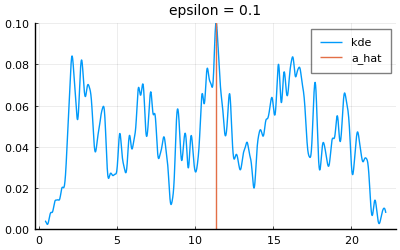

┌ Info: Saved animation to 
│   fn = C:\Users\4429s\codes\mathcodes\julia\statistics\images\004_mode_estimation.gif
└ @ Plots C:\Users\4429s\.julia\packages\Plots\6EMd6\src\animation.jl:104


In [18]:
a = range(extrema(X)..., length=2000)
@time anim = @animate for ε in range(0.1, 3.0, step=0.1)
    a_hat = a[findmax(Ln.(a; ε=ε))[2]]    
    plot(a, Ln.(a; ε=ε), legend=:topright, label="kde", ylim=(0.0, 0.1))
    vline!([a_hat], label="a_hat")
    title!("epsilon = $ε")
end
pyplotclf()
gif(anim, "images/004_mode_estimation.gif", fps=5)
displayfile("image/gif", "images/004_mode_estimation.gif")

## 加法平均と乗法平均
- [目次へ](#目次)

### ディガンマ関数（digamma函数）に関するプロット


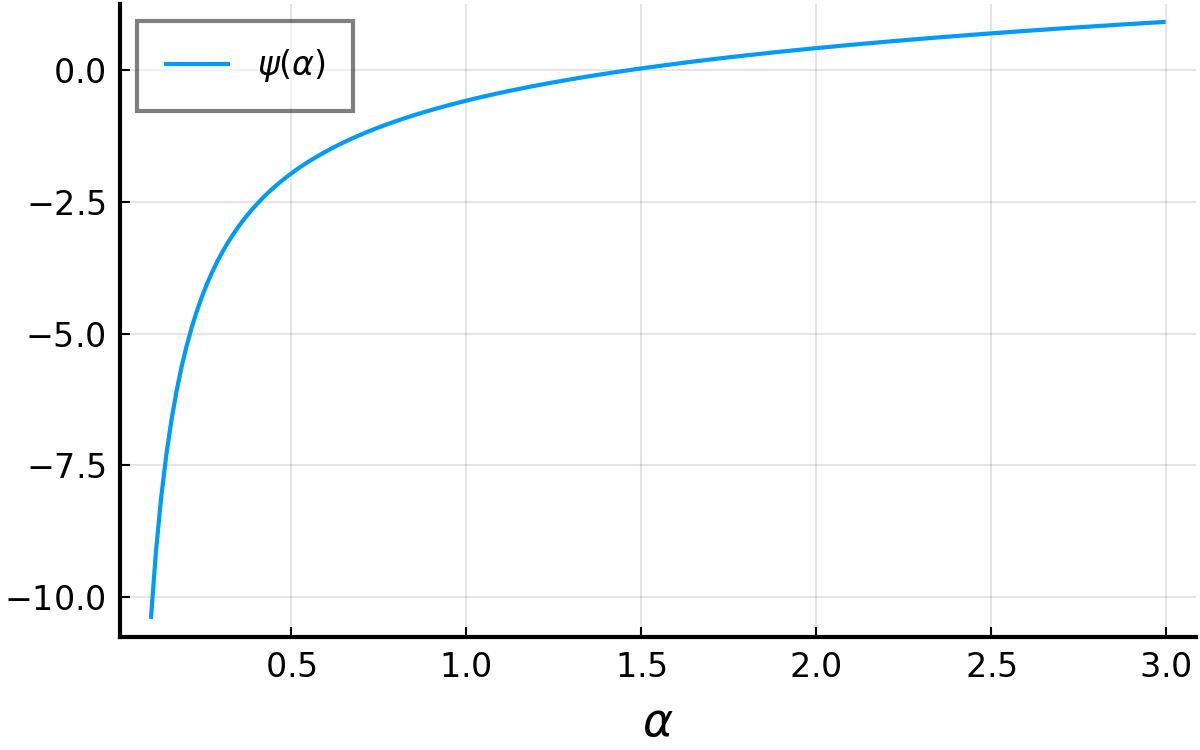

In [19]:
α = range(0.1, 3, length=200)
plot(α, digamma.(α), xlabel="\$\\alpha\$", label="\$\\psi(\\alpha)\$") |> retina

### $\log(\alpha) - \psi(\alpha)$のプロット
狭義単調減少です。


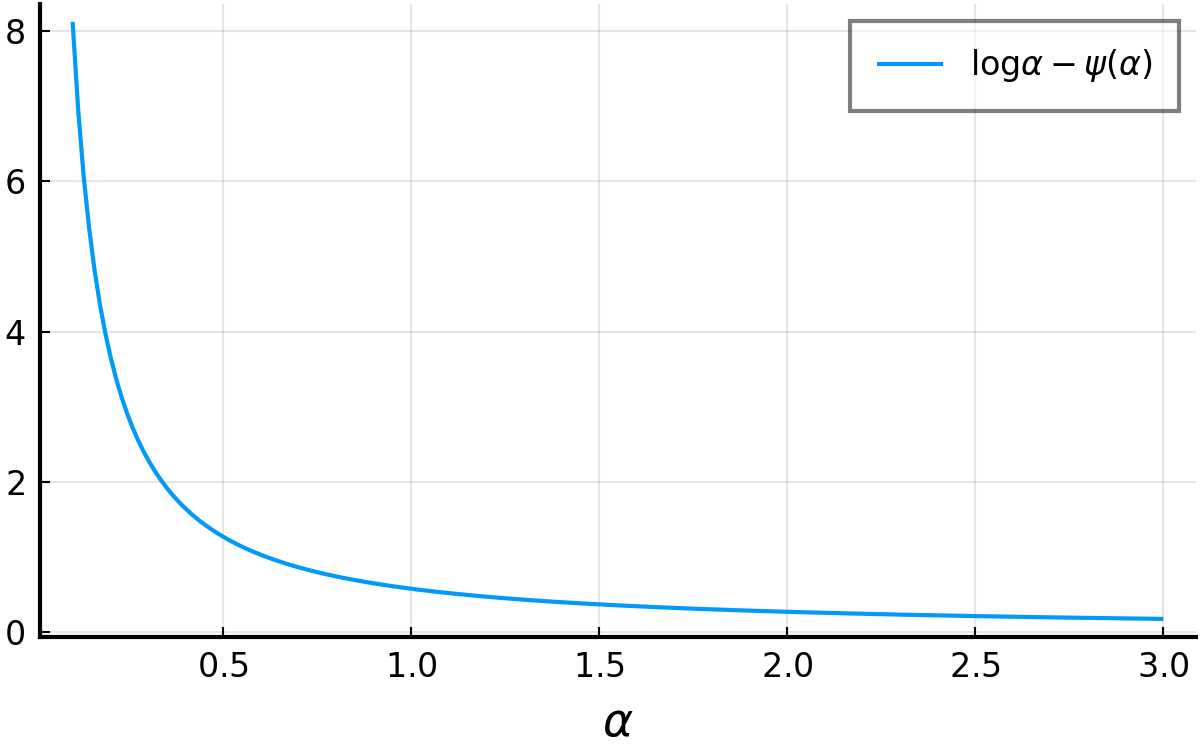

In [20]:
f(α) = log(α) - digamma(α)
α = range(0.1, 3, length=200)
plot(α, f.(α), xlabel="\$\\alpha\$", label="\$\\log\\alpha - \\psi(\\alpha)\$") |> retina

### ガンマ分布モデルによる推定の例
- [目次へ](#目次)

#### ガンマ分布の混合モデル


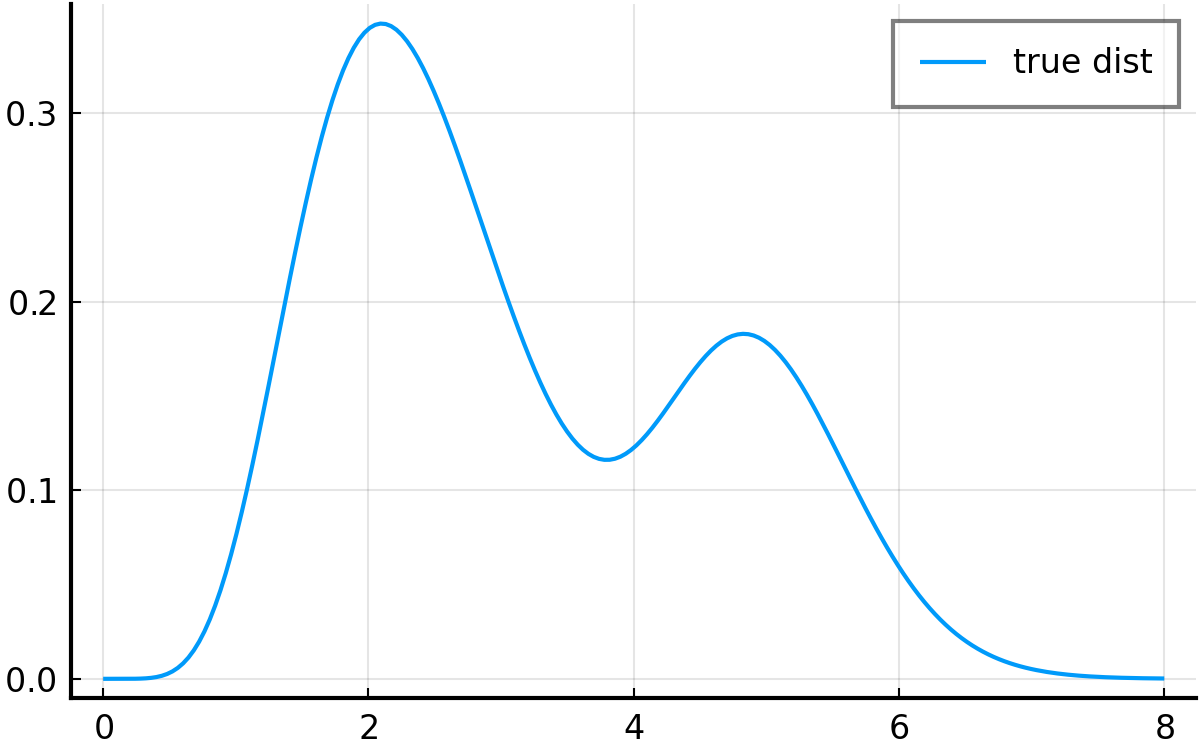

In [21]:
dist_mg = MixtureModel([Gamma(8,0.3), Gamma(50, 0.1)], [0.7, 0.3])
x = range(0, 8, length=200)
plot(x, pdf.(dist_mg, x), label="true dist") |> retina

#### ガンマ分布の混合モデルからのサンプル


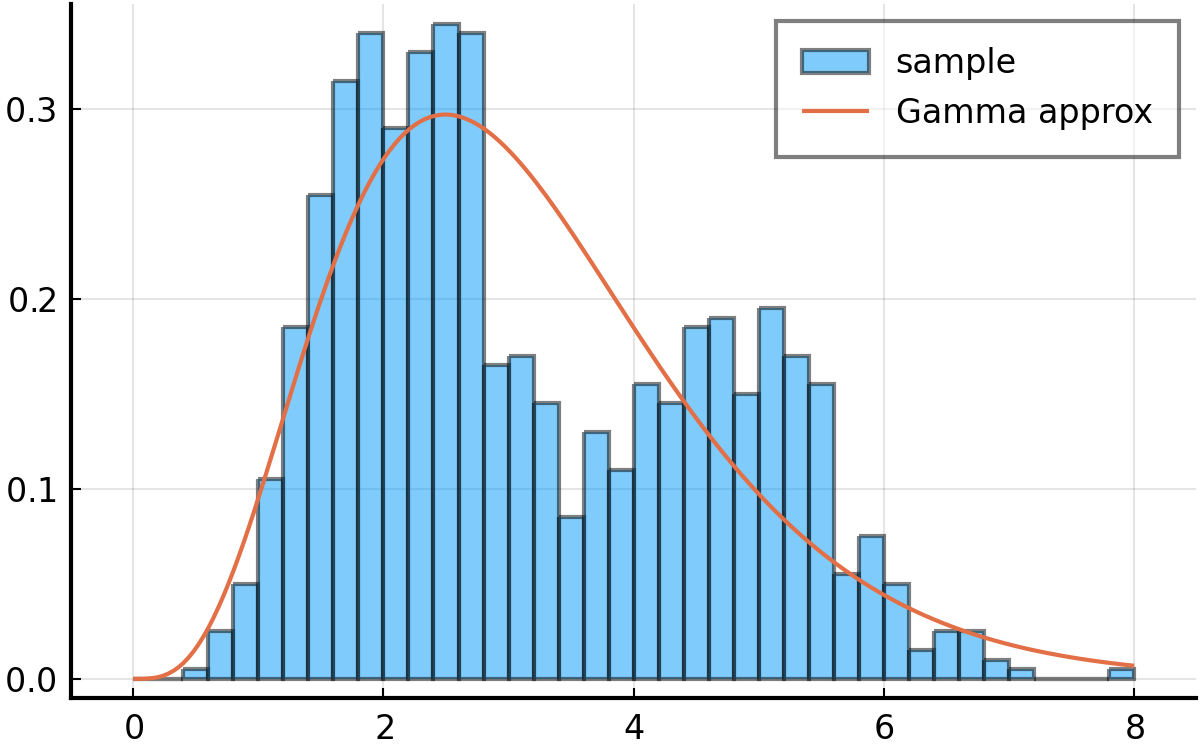

dist_g = fit_mle(Gamma, X) = Gamma{Float64}(α=4.616381789806062, θ=0.6900194818080877)


In [22]:
Random.seed!(seed)
N = 1000

X = rand(dist_mg, N)
@show dist_g = fit_mle(Gamma, X) # 単独のガンマ分布で最尤推定
histogram(X, norm=true, bins=range(0, 8, step=0.2), label="sample", alpha=0.5)
plot!(x, pdf.(dist_g, x), label="Gamma approx") |> retina

#### 尤度函数のプロット
対象の関数は`loglik(α, θ) = sum(logpdf(Gamma(α, θ), x) for x in X)`。

282.206247 seconds (27.38 M allocations: 1003.453 MiB, 0.13% gc time)



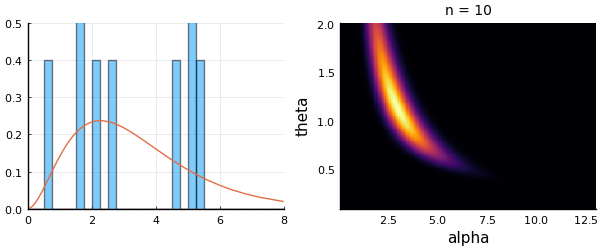

┌ Info: Saved animation to 
│   fn = C:\Users\4429s\codes\mathcodes\julia\statistics\images\004_lik_gamma.gif
└ @ Plots C:\Users\4429s\.julia\packages\Plots\6EMd6\src\animation.jl:104


In [23]:
Random.seed!(seed)

N = 300
XX = rand(dist_mg, N)

ns = [fill(10, 10); 10:3:300; 300; fill(300, 10)]
@time anim = @animate for n in ns
    X = @view XX[1:n]

    dist_g = fit_mle(Gamma, X)
    P1 = histogram(X; normed=true, bins=range(0, 8, step=0.25), alpha=0.5, label="sample")
    plot!(x -> pdf(dist_g, x), 0, 8; label="Gamma approx")
    plot!(legend=false, xlim=(0, 8), ylim=(0, 0.5))

    loglik(α, θ) = sum(logpdf(Gamma(α, θ), x) for x in X)
    α = range(0.1, 13, length=200)
    θ = range(0.1, 2.0, length=200)
    P2 = heatmap(α, θ, exp.(loglik.(α', θ));
        xlabel="alpha", ylabel="theta",
        size=(300, 320), colorbar=false, title="n = $n") # 尤度に関するヒートマップ
    
    plot(P1, P2, size=(600, 250))
end
pyplotclf()
gif(anim, "images/004_lik_gamma.gif", fps=10)
displayfile("image/gif", "images/004_lik_gamma.gif")

#### グラフについて
$n$が大きくなるとどんどん$\alpha, \theta$の範囲が小さくなる。

#### 尤度函数のプロット
対象の関数は`loglik(α, μ) = sum(logpdf(Gamma(α, μ/α), x) for x in X)`。

287.985231 seconds (27.37 M allocations: 1003.549 MiB, 0.15% gc time)



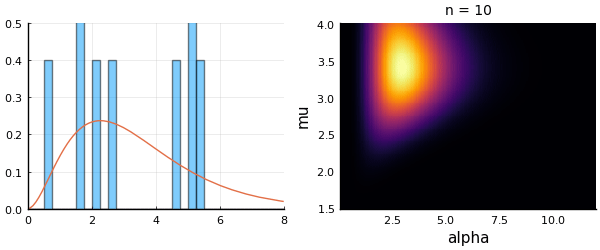

┌ Info: Saved animation to 
│   fn = C:\Users\4429s\codes\mathcodes\julia\statistics\images\004_lik_gamma2.gif
└ @ Plots C:\Users\4429s\.julia\packages\Plots\6EMd6\src\animation.jl:104


In [24]:
Random.seed!(seed)

N = 300
XX = rand(dist_mg, N)

ns = [fill(10, 10); 10:3:300; 300; fill(300, 10)]
@time anim = @animate for n in ns
    X = @view XX[1:n]

    dist_g = fit_mle(Gamma, X)
    P1 = histogram(X; normed=true, bins=range(0, 8, step=0.25), alpha=0.5, label="sample")
    plot!(x -> pdf(dist_g, x), 0, 8; label="Gamma approx")
    plot!(legend=false, xlim=(0, 8), ylim=(0, 0.5))

    loglik(α, μ) = sum(logpdf(Gamma(α, μ/α), x) for x in X)
    α = range(0.1, 12, length=200)
    μ = range(1.5, 4, length=200)
    P2 = heatmap(α, μ, exp.(loglik.(α', μ)); xlabel="alpha", ylabel="mu",
        size=(300, 320), colorbar=false, title="n = $n")
    
    plot(P1, P2, size=(600, 250))
end
pyplotclf()
gif(anim, "images/004_lik_gamma2.gif", fps=10)
displayfile("image/gif", "images/004_lik_gamma2.gif")

#### 尤度函数のプロット
対象の関数は`loglik(α, μ) = sum(logpdf(Gamma(α, μ/α), x) for x in X)`で先ほどと同じだが、
`ns`と`α`の取る範囲が違う。

 94.600256 seconds (19.79 M allocations: 729.265 MiB, 0.26% gc time)



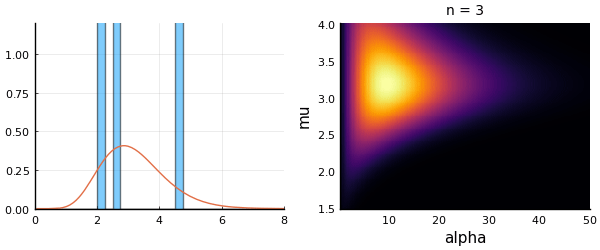

┌ Info: Saved animation to 
│   fn = C:\Users\4429s\codes\mathcodes\julia\statistics\images\004_lik_gamma3.gif
└ @ Plots C:\Users\4429s\.julia\packages\Plots\6EMd6\src\animation.jl:104


In [25]:
Random.seed!(seed)

N = 300
XX = rand(dist_mg, N)

ns = [fill(3, 6); 4;4;4;4;5;5;5;6;6;6;7;7;8;8;9;9; 10:20; 23:3:100; 110:10:300 ; fill(300, 5)]
@time anim = @animate for n in ns
    X = @view XX[1:n]

    dist_g = fit_mle(Gamma, X)
    P1 = histogram(X; normed=true, bins=range(0, 8, step=0.25), alpha=0.5, label="sample")
    plot!(x -> pdf(dist_g, x), 0, 8; label="Gamma approx")
    plot!(legend=false, xlim=(0, 8), ylim=(0, 1.2))

    loglik(α, μ) = sum(logpdf(Gamma(α, μ/α), x) for x in X)
    α = range(0.5, 50, length=200)
    μ = range(1.5, 4, length=200)
    P2 = heatmap(α, μ, exp.(loglik.(α', μ)); xlabel="alpha", ylabel="mu",
        size=(300, 320), colorbar=false, title="n = $n")
    
    plot(P1, P2, size=(600, 250))
end
pyplotclf()
gif(anim, "images/004_lik_gamma3.gif", fps=3)
displayfile("image/gif", "images/004_lik_gamma3.gif")